# Kaggle
## Competition NFL Big Data Bowl

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
# Carregando os pacotes
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Statistic lib
from scipy import stats
from scipy.stats import skew, norm

# Sklearn lib
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

# Models
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from mlxtend.regressor import StackingCVRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
import xgboost as XGB
from sklearn.cluster import KMeans
import tqdm

# Misc lib
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

#!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

# Utils
from functools import partial
from IPython.display import Image
import pandasql as ps
import re 
import math, string, os
import datetime

# Options
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000
pd.set_option('display.max_columns', None)
import gc
gc.enable()

/Users/rodrigolima82/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
# Carregando os dados de treino
train = pd.read_csv('../data/train.csv')
#train = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2020/train.csv', low_memory=False)
print ("Data is ready !!")

Data is ready !!


# Criando as funções auxiliares de limpeza e conversao

In [4]:
# Funcao para tratar os dados missing de cada variavel
def fill_na(data):
    data['WindDirection'].fillna('unknown',inplace=True)
    data['OffenseFormation'].fillna('unknown',inplace=True)
    data['StadiumType'].fillna('unknown',inplace=True)
    data['GameWeather'].fillna('unknown',inplace=True)
    data['FieldPosition'].fillna('NA',inplace=True)
    
    data['Temperature'].fillna(data['Temperature'].mean(), inplace=True)
    data['Humidity'].fillna(data['Humidity'].mean(), inplace=True)
    data['DefendersInTheBox'].fillna(math.ceil(data['DefendersInTheBox'].mean()),inplace=True)
    
# Funcao para agrupar as descricoes dos tipos de estadio
def agrupar_tipo_estadio(StadiumType):
    outdoor       = ['Outdoor', 'Outdoors', 'Cloudy', 'Heinz Field', 'Outdor', 'Ourdoor', 'Outside', 'Outddors', 'Outdoor Retr Roof-Open', 'Oudoor', 'Bowl']
    indoor_closed = ['Indoors', 'Indoor', 'Indoor, Roof Closed', 'Indoor, Roof Closed', 'Retractable Roof', 'Retr. Roof-Closed', 'Retr. Roof - Closed', 'Retr. Roof Closed']
    indoor_open   = ['Indoor, Open Roof', 'Open', 'Retr. Roof-Open', 'Retr. Roof - Open']
    dome_closed   = ['Dome', 'Domed, closed', 'Closed Dome', 'Domed', 'Dome, closed']
    dome_open     = ['Domed, Open', 'Domed, open']
    
    if StadiumType in outdoor:
        return 'outdoor'
    elif StadiumType in indoor_closed:
        return 'indoor_closed'
    elif StadiumType in indoor_open:
        return 'indoor_open'
    elif StadiumType in dome_closed:
        return 'dome_closed'
    elif StadiumType in dome_open:
        return 'dome_open'
    else:
        return 'unknown' # se for n/a
    
# Funcao para agrupar as descricoes dos estadios
def agrupar_estadio(Stadium):

    if Stadium == 'Broncos Stadium at Mile High':
        return 'Broncos Stadium At Mile High'
    
    elif Stadium in ('CenturyField', 'CenturyLink'):
        return 'CenturyLink Field'
    
    elif Stadium == 'EverBank Field':
        return 'Everbank Field'
    
    elif Stadium in ('FirstEnergy', 'FirstEnergy Stadium', 'FirstEnergyStadium'):
        return 'First Energy Stadium'
   
    elif Stadium == 'Lambeau field':
        return 'Lambeau Field'

    elif Stadium == 'Los Angeles Memorial Coliesum':
        return 'Los Angeles Memorial Coliseum'
    
    elif Stadium in ('M & T Bank Stadium', 'M&T Stadium'):
        return 'M&T Bank Stadium'

    elif Stadium in ('Mercedes-Benz Dome', 'Mercedes-Benz Superdome'):
        return 'Mercedes-Benz SuperDome'
    
    elif Stadium in ('MetLife Stadium', 'Metlife Stadium', 'MetLife'):
        return 'MetLife Stadium' 
    
    elif Stadium == 'NRG':
        return 'NRG Stadium' 

    elif Stadium == 'Oakland-Alameda County Coliseum':
        return 'Oakland Alameda-County Coliseum' 
    
    elif Stadium == 'Paul Brown Stdium':
        return 'Paul Brown Stadium' 

    elif Stadium == 'Twickenham':
        return 'Twickenham Stadium' 
    
    else:
        return Stadium
    
# Funcao para agrupar a localizacao do estadio e do jogo
def agrupar_local(Location):

    if Location == "Arlington, Texas":
        return "Arlington, TX"
    elif Location in ("Baltimore, Maryland","Baltimore, Md."):
        return "Baltimore, MD"
    elif Location == "Charlotte, North Carolina":
        return "Charlotte, NC"
    elif Location == "Chicago. IL":
        return "Chicago, IL"
    elif Location == "Cincinnati, Ohio":
        return "Cincinnati, OH"
    elif Location in ("Cleveland","Cleveland Ohio","Cleveland, Ohio","Cleveland,Ohio"):
        return "Cleveland, OH"
    elif Location == "Detroit":
        return "Detroit, MI"
    elif Location == "E. Rutherford, NJ" or Location == "East Rutherford, N.J.":
        return "East Rutherford, NJ"
    elif Location == "Foxborough, Ma":
        return "Foxborough, MA"
    elif Location == "Houston, Texas":
        return "Houston, TX"
    elif Location in ("Jacksonville Florida","Jacksonville, Fl","Jacksonville, Florida"):
        return "Jacksonville, FL"
    elif Location == "London":
        return "London, England"
    elif Location == "Los Angeles, Calif.":
        return "Los Angeles, CA"
    elif Location == "Miami Gardens, Fla.":
        return "Miami Gardens, FLA"
    elif Location in ("New Orleans","New Orleans, La."):
        return "New Orleans, LA"
    elif Location == "Orchard Park NY":
        return "Orchard Park, NY"
    elif Location == "Philadelphia, Pa.":
        return "Philadelphia, PA"
    elif Location == "Pittsburgh":
        return "Pittsburgh, PA"
    elif Location == "Seattle":
        return "Seattle, WA"
    else:
        return Location
    
# Funcao para agrupar o gramado do estadio
def agrupar_gramado(Turf):
    if Turf == 'Artifical':
        return 'Artificial'
    
    elif Turf in ('FieldTurf', 'Field turf'):
        return 'Field Turf'

    elif Turf in ('FieldTurf360', 'FieldTurf 360'):
        return 'Field Turf 360'

    elif Turf in ('Natural', 'Natural grass', 'Naturall Grass', 'grass', 'natural grass', 'SISGrass', 'Natural Grass'):
        return "Grass"

    elif Turf == "UBU Sports Speed S5-M":
        return "UBU Speed Series-S5-M"

    else:
        return Turf

# Funcao para agrupar os dados de direcao do vento
def agrupa_wind_direction(WindDirection):
    wd = str(WindDirection).upper()
    
    if wd == 'N' or 'FROM N' in wd:
        return 'north'
    if wd == 'S' or 'FROM S' in wd:
        return 'south'
    if wd == 'W' or 'FROM W' in wd:
        return 'west'
    if wd == 'E' or 'FROM E' in wd:
        return 'east'
    
    if 'FROM SW' in wd or 'FROM SSW' in wd or 'FROM WSW' in wd:
        return 'south west'
    if 'FROM SE' in wd or 'FROM SSE' in wd or 'FROM ESE' in wd:
        return 'south east'
    if 'FROM NW' in wd or 'FROM NNW' in wd or 'FROM WNW' in wd:
        return 'north west'
    if 'FROM NE' in wd or 'FROM NNE' in wd or 'FROM ENE' in wd:
        return 'north east'
    
    if 'NW' in wd or 'NORTHWEST' in wd:
        return 'north west'
    if 'NE' in wd or 'NORTH EAST' in wd:
        return 'north east'
    if 'SW' in wd or 'SOUTHWEST' in wd:
        return 'south west'
    if 'SE' in wd or 'SOUTHEAST' in wd:
        return 'south east'

    return 'unknown'

# Funcao para agrupar as descricoes de clima
def agrupar_clima(GameWeather):
    chuva   = ['Rainy', 'Rain Chance 40%', 'Showers',
               'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
               'Scattered Showers', 'Cloudy, Rain', 'Rain shower', 'Light Rain', 'Rain']
    nublado = ['Cloudy, light snow accumulating 1-3"', 'Party Cloudy', 'Cloudy, chance of rain',
               'Coudy', 'Cloudy, 50% change of rain', 'Rain likely, temps in low 40s.',
               'Cloudy and cold', 'Cloudy, fog started developing in 2nd quarter',
               'Partly Clouidy', '30% Chance of Rain', 'Mostly Coudy', 'Cloudy and Cool',
               'cloudy', 'Partly cloudy', 'Overcast', 'Hazy', 'Mostly cloudy', 'Mostly Cloudy',
               'Partly Cloudy', 'Cloudy']
    limpo   = ['Partly clear', 'Sunny and clear', 'Sun & clouds', 'Clear and Sunny',
               'Sunny and cold', 'Sunny Skies', 'Clear and Cool', 'Clear and sunny',
               'Sunny, highs to upper 80s', 'Mostly Sunny Skies', 'Cold',
               'Clear and warm', 'Sunny and warm', 'Clear and cold', 'Mostly sunny',
               'T: 51; H: 55; W: NW 10 mph', 'Clear Skies', 'Clear skies', 'Partly sunny',
               'Fair', 'Partly Sunny', 'Mostly Sunny', 'Clear', 'Sunny']
    neve    = ['Heavy lake effect snow', 'Snow']
    none    = ['N/A Indoor', 'Indoors', 'Indoor', 'N/A (Indoors)', 'Controlled Climate']

    
    if GameWeather in chuva:
        return 'chuva'
    elif GameWeather in nublado:
        return 'nublado'
    elif GameWeather in limpo:
        return 'limpo'
    elif GameWeather in neve:
        return 'neve'
    elif GameWeather in none:
        return 'none'
    else:
        return 'none' # se for n/a
    
# Funcao para converter a velocidade do vento
def convert_wind_speed(WindSpeed):
    ws = str(WindSpeed)

    if ws.isdigit():
        return int(ws)

    if '-' in ws:
        return int(ws.split('-')[0])

    if ws.split(' ')[0].isdigit():
        return int(ws.split(' ')[0])

    if 'mph' in ws.lower():
        return int(ws.lower().split('mph')[0])
    else:
        return 0
    
    
# Funcao para converter altura de feet-inches para centimetros
def convert_to_cm(ft_in):
    h_ft   = int(ft_in.split('-')[0])
    h_inch = int(ft_in.split('-')[1])
    h_inch += h_ft * 12
    h_cm = round(h_inch * 2.54, 1)
    #print("Your height is : %d cm." % h_cm)   
    
    return h_cm

# Funcao para converter peso em lbs para kg
def convert_to_kg(lbs):
    kg = lbs * 0.45359237
    #print("The weight is", kg, "in kilograms")
    
    return kg

# Funcao para converter temperatura Fahrenheit para Celsius
def convert_to_celsius(fah):
    celsius = (fah - 32) * 5.0/9.0
    #print("Temperature:", fah, "Fahrenheit = ", celsius, " C")
    return celsius

# Funcao para converter as features de data e extrair dia, mes, ano, hora, minuto, segundo
def convert_data(data):
    #data['PlayerBirthDate'] = pd.to_datetime(data['PlayerBirthDate'], "%m/%d/%Y")
    data['PlayerBirthDate'] = data['PlayerBirthDate'].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y"))
    data['PlayerBirthDate_day'] = data['PlayerBirthDate'].dt.day.astype(int)
    data['PlayerBirthDate_month'] = data['PlayerBirthDate'].dt.month.astype(int)
    data['PlayerBirthDate_year'] = data['PlayerBirthDate'].dt.year.astype(int)

    data['TimeSnap'] = data['TimeSnap'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
    #data['TimeSnap'] = pd.to_datetime(data['TimeSnap'], "%Y-%m-%dT%H:%M:%S.%fZ")
    data['TimeSnap_min'] = data['TimeSnap'].dt.minute.astype(int)
    data['TimeSnap_seg'] = data['TimeSnap'].dt.second.astype(int)
    
    data['TimeHandoff'] = data['TimeHandoff'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
    #data['TimeHandoff'] = pd.to_datetime(data['TimeHandoff'], "%Y-%m-%dT%H:%M:%S.%fZ")
    data['TimeHandoff_min'] = data['TimeHandoff'].dt.minute.astype(int)
    data['TimeHandoff_seg'] = data['TimeHandoff'].dt.second.astype(int)
    

    
# Funcao para converter uma string horario em segundos
def str_to_seconds(time):
    time = time.split(':')
    sec = int(time[0])*60 + int(time[1]) + int(time[2])/60
    return sec

    
# Funcao para criar novas colunas agregadas
def uid_aggregation(comb, main_columns, uids, aggregations):
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = col+'_'+main_column+'_'+agg_type
                temp_df = comb[[col, main_column]]
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                comb[new_col_name] = comb[col].map(temp_df)
                del temp_df
                gc.collect()
    return comb

# Funcao para criar um plot de distribuicao para cada feature
def plot_distribution(dataset, cols=5, width=20, height=25, hspace=0.4, wspace=0.5):
    """
    Plot distributions for each column in a dataset.
    Seaborn countplots are used for categorical data and distplots for numerical data

    args:
    ----
    dataset {dataframe} - the data that will be plotted
    cols {int} - how many distributions to plot for each row
    width {int} - how wide each plot should be
    height {int} - how tall each plot should be
    hspace {float} - horizontal space between plots
    wspace {float} - vertical space between plots 
    """
    # plot styling
    plt.style.use('fivethirtyeight')
    fig = plt.figure(figsize=(width, height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    # calculate rows needed
    rows = math.ceil(float(dataset.shape[1]) / cols)
    # create a countplot for top 20 categorical values
    # and a distplot for all numerical values
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object:
            # grab the top 10 for each countplot
            g = sns.countplot(y=column, 
                              data=dataset,
                              order=dataset[column].value_counts().index[:10])
            # make labels only 20 characters long and rotate x labels for nicer displays
            substrings = [s.get_text()[:20] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xticks(rotation=25)
        else:
            g = sns.distplot(dataset[column])
            plt.xticks(rotation=25)

# Feature Engineering

In [5]:
# Funcao para realizar feature engineering no dataset (treino ou teste)
def feature_engineering(df): 
    
    # Limpeza e conversao dos dados
    fill_na(df)
    convert_data(df)
    
    # Conversao de algumas features
    df['PlayerHeight']  = df['PlayerHeight'].apply(convert_to_cm)
    df['PlayerWeight']  = df['PlayerWeight'].apply(convert_to_kg)
    df['Temperature']   = df['Temperature'].apply(convert_to_celsius)
    df['StadiumType']   = df['StadiumType'].apply(agrupar_tipo_estadio)
    df['Stadium']       = df['Stadium'].apply(agrupar_estadio)
    df['Location']      = df['Location'].apply(agrupar_local)
    df['Turf']          = df['Turf'].apply(agrupar_gramado)
    df['WindDirection'] = df['WindDirection'].apply(agrupa_wind_direction)
    df['WindSpeed']     = df['WindSpeed'].apply(convert_wind_speed)
    df['GameWeather']   = df['GameWeather'].apply(agrupar_clima)


    # Corrigindo a feature Stadium
    df.loc[df['Stadium'] == 'MetLife Stadium', 'StadiumType'] = 'outdoor'
    df.loc[df['Stadium'] == 'StubHub Center', 'StadiumType'] = 'outdoor'    
    
    # Nova feature com a diferença entre o tempo de lançamento da bola até quando o jogador captura
    df['TimeDifer'] = df.apply(lambda row: (row['TimeHandoff'] - row['TimeSnap']).total_seconds(), axis=1)            
         
    # Nova feature para indicar se é o jogador que esta realizando a jogada (corredor)
    df['IsRusher'] = df['NflId'] == df['NflIdRusher']
    
    # Novas features com base no horario do jogo
    df['Morning']   = df['GameClock'].apply(lambda x : 1 if (int(x[0:2]) >=0 and int(x[0:2]) <12) else 0)
    df['Afternoon'] = df['GameClock'].apply(lambda x : 1 if (int(x[0:2]) <18 and int(x[0:2]) >=12) else 0)
    df['Evening']   = df['GameClock'].apply(lambda x : 1 if (int(x[0:2]) >= 18 and int(x[0:2]) < 24) else 0)
    df['GameClock'] = df['GameClock'].apply(str_to_seconds) 
    
    # Criando novas features com base na coluna DefensePersonnel
    DP = [['0_DL','1_DL','2_DL','3_DL','4_DL','5_DL','6_DL','7_DL'],
          ['0_LB','1_LB','2_LB','3_LB','4_LB','5_LB','6_LB'],
          ['1_DB','2_DB','3_DB','4_DB','5_DB','6_DB','7_DB','8_DB']]
    
    for k in range(0,3) :
        for col in DP[k] :
            df[col] = df['DefensePersonnel'].str.replace(' ','_').str.split(',_').apply(lambda x : 1 if (x[k] == col) else 0)
            
    # Criando novas features com base na coluna OffensePersonnel
    OP = [['1_RB','2_RB','3_RB','6_OL','7_OL','2_QB'],
          ['1_TE','2_TE','3_TE','1_RB','2_RB','3_RB','0_TE','1_TE','2_TE','3_TE','4_TE'],
          ['1_DB','1_WR','2_WR','3_WR','4_WR','5_WR','0_TE','1_TE','2_TE','3_TE','8_DB']]

    for k in range(0,3) :
        for col in OP[k] :
            df[col] = df['OffensePersonnel'].str.replace(' ','_').str.split(',_').apply(lambda x : 1 if (x[k] == col) else 0)

    # Criando novas features com dados de Distance, YardLine e DefendersInTheBox
    df['seconds_need_to_first_down'] = (df['Distance']*0.9144)/df['Dis']
    df['seconds_need_to_YardsLine'] = (df['YardLine']*0.9144)/df['Dis']    
    df['DefendersInTheBox_vs_Distance'] = df['DefendersInTheBox'] / df['Distance']

    for i in range(1,23) :
        for j in ['X','Y','S','A','YardLine'] :
            df[j+"_"+str(i)] = df[j].shift(i)
    
    # Cria um label encoder object
    le = preprocessing.LabelEncoder()

    # Iteracao para cada coluna do dataset de treino
    for col in df:
        if df[col].dtype == 'object':
            le.fit_transform(df[col].astype(str))
            df[col] = le.transform(df[col])      


    # Ordenacao do dataset e renovando o index
    df = df.sort_values(by=['PlayId', 'Team', 'IsRusher']).reset_index()
    
    # Removendo colunas que não serão utilizadas
    df = df.drop(['index','Yards','GameId','PlayId','NflId', 'DisplayName','NflIdRusher', 'TimeHandoff', 'TimeSnap', 'PlayerBirthDate'], axis=1)

    # Atribuindo -999 para os demais dados missing
    df.fillna(-999, inplace=True)
    
    return df

In [6]:
# Criando um novo dataset aplicando Feature Engineering
train_df = feature_engineering(train)

In [7]:
train_df.fillna(0,inplace=True)
train_df.replace(-np.inf,0,inplace=True)
train_df.replace(np.inf,0,inplace=True)

In [8]:
train_df.head()

,Team,X,Y,S,A,Dis,Orientation,Dir,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,PlayerHeight,PlayerWeight,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,PlayerBirthDate_day,PlayerBirthDate_month,PlayerBirthDate_year,TimeSnap_min,TimeSnap_seg,TimeHandoff_min,TimeHandoff_seg,TimeDifer,IsRusher,Morning,Afternoon,Evening,0_DL,1_DL,2_DL,3_DL,4_DL,5_DL,6_DL,7_DL,0_LB,1_LB,2_LB,3_LB,4_LB,5_LB,6_LB,1_DB,2_DB,3_DB,4_DB,5_DB,6_DB,7_DB,8_DB,1_RB,2_RB,3_RB,6_OL,7_OL,2_QB,1_TE,2_TE,3_TE,0_TE,4_TE,1_WR,2_WR,3_WR,4_WR,5_WR,seconds_need_to_first_down,seconds_need_to_YardsLine,DefendersInTheBox_vs_Distance,X_1,Y_1,S_1,A_1,YardLine_1,X_2,Y_2,S_2,A_2,YardLine_2,X_3,Y_3,S_3,A_3,YardLine_3,X_4,Y_4,S_4,A_4,YardLine_4,X_5,Y_5,S_5,A_5,YardLine_5,X_6,Y_6,S_6,A_6,YardLine_6,X_7,Y_7,S_7,A_7,YardLine_7,X_8,Y_8,S_8,A_8,YardLine_8,X_9,Y_9,S_9,A_9,YardLine_9,X_10,Y_10,S_10,A_10,YardLine_10,X_11,Y_11,S_11,A_11,YardLine_11,X_12,Y_12,S_12,A_12,YardLine_12,X_13,Y_13,S_13,A_13,YardLine_13,X_14,Y_14,S_14,A_14,YardLine_14,X_15,Y_15,S_15,A_15,YardLine_15,X_16,Y_16,S_16,A_16,YardLine_16,X_17,Y_17,S_17,A_17,YardLine_17,X_18,Y_18,S_18,A_18,YardLine_18,X_19,Y_19,S_19,A_19,YardLine_19,X_20,Y_20,S_20,A_20,YardLine_20,X_21,Y_21,S_21,A_21,YardLine_21,X_22,Y_22,S_22,A_22,YardLine_22
0,0,73.91,34.84,1.69,1.13,0.40,81.99,177.18,29,2017,35,1,854.0,20,3,2,21,0,0,5,9,6.0,8,0,182.9,96.161582,246,21,20,15,1,10,11,4,3,1,17.222222,77.0,0,6,29,12,1988,44,5,44,6,1.0,False,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4.572000,80.01000,3.0,-999.00,-999.00,-999.00,-999.00,-999.0,-999.00,-999.00,-999.00,-999.00,-999.0,-999.00,-999.00,-999.00,-999.00,-999.0,-999.00,-999.00,-999.00,-999.00,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
1,0,74.67,32.64,0.42,1.35,0.01,27.61,198.70,97,2017,35,1,854.0,20,3,2,21,0,0,5,9,6.0,8,0,190.5,130.634603,138,3,20,15,1,10,11,4,3,1,17.222222,77.0,0,6,25,3,1989,44,5,44,6,1.0,False,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,182.880000,3200.40000,3.0,73.91,34.84,1.69,1.13,35.0,-999.00,-999.00,-999.00,-999.00,-999.0,-999.00,-999.00,-999.00,-999.00,-999.0,-999.00,-999.00,-999.00,-999.00,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
2,0,74.00,33.20,1.22,0.59,0.31,3.01,202.73,50,2017,35,1,854.0,20,3,2,21,0,0,5,9,6.0,8,0,190.5,122.469940,81,3,20,15,1,10,11,4,3,1,17.222222,77.0,0,6,21,1,1989,44,5,44,6,1.0,False,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,5.899355,103.23871,3.0,74.67,32.64,0.42,1.35,35.0,73.91,34.84,1.69,

# Criação e Validação dos Modelos de ML

## Algumas considerações deste processo:
- **Cross Validation:** Estou usando 5-fold cross-validation
- **Models:** Random Forest Regression

####  Validação
Continuous Ranked Probability Score (CRPS) is derived based on the predicted scalar value.
The CRPS is computed as follows:
$$
C=\frac{1}{199N}\sum_{m=1}^N\sum_{n=-99}^{99}(P(y\geq n)-H(n-Y_m))^2
$$
$H(x)=1$ if $x\geq 0$ else $0$

In [9]:
# Fazendo uma limpeza na memoria
gc.collect()

55

In [10]:
# Setup cross validation folds
kf = 5
folds = KFold(n_splits=kf, shuffle=False, random_state=42)
print(str(kf) + ' Folds para treino...')

5 Folds para treino...


In [11]:
# Identificando as features para o modelo
features = list(train_df.columns)
X = train_df[features]
print(len(features),' features')
np.array(features)

204  features


array(['Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation', 'Dir',
       'JerseyNumber', 'Season', 'YardLine', 'Quarter', 'GameClock',
       'PossessionTeam', 'Down', 'Distance', 'FieldPosition',
       'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'OffenseFormation', 'OffensePersonnel', 'DefendersInTheBox',
       'DefensePersonnel', 'PlayDirection', 'PlayerHeight',
       'PlayerWeight', 'PlayerCollegeName', 'Position', 'HomeTeamAbbr',
       'VisitorTeamAbbr', 'Week', 'Stadium', 'Location', 'StadiumType',
       'Turf', 'GameWeather', 'Temperature', 'Humidity', 'WindSpeed',
       'WindDirection', 'PlayerBirthDate_day', 'PlayerBirthDate_month',
       'PlayerBirthDate_year', 'TimeSnap_min', 'TimeSnap_seg',
       'TimeHandoff_min', 'TimeHandoff_seg', 'TimeDifer', 'IsRusher',
       'Morning', 'Afternoon', 'Evening', '0_DL', '1_DL', '2_DL', '3_DL',
       '4_DL', '5_DL', '6_DL', '7_DL', '0_LB', '1_LB', '2_LB', '3_LB',
       '4_LB', '5_LB', '6_LB', '1_DB', '2_DB', '3_DB', '4

In [12]:
# Criando matriz de treino
train_data = np.zeros((509762//22,len(features))) 

for i in tqdm.tqdm(range(0,509762,22)):
    count=0
    for c in features:
        train_data[i//22][count] = train_df[c][i]
        count+=1

100%|██████████| 23171/23171 [00:58<00:00, 394.46it/s]


In [13]:
# Split de dados e label
X_train = pd.DataFrame(data=train_data,columns=features)
y_train_ = np.array([train["Yards"][i] for i in range(0,509762,22)])

In [ ]:
# Normalizacao das features 
y_tr = np.zeros(len(y_train_),dtype=np.float)
for i in range(len(y_tr)):
    y_tr[i]=(y_train_[i])

scaler = preprocessing.StandardScaler()
scaler.fit([[y] for y in y_tr])
y_tr = np.array([y[0] for y in scaler.transform([[y] for y in y_tr])])

In [15]:
def funcao_crps(labels,predictions) :
    y_pred = np.zeros((len(labels),199))
    y_ans = np.zeros((len(labels),199))
    j = np.array(range(199))
    for i,(p,t) in enumerate(zip(np.round(scaler.inverse_transform(predictions)),labels)) :
        k2 = j[j>=p-10]
        y_pred[i][k2]=(k2+10-p)*0.05
        k1 = j[j>=p+10]
        y_pred[i][k1]= 1.0
        k3 = j[j>=t]
        y_ans[i][k3]= 1.0
                           
    return 'CRPS: ', np.sum((y_pred-y_ans)**2)/(199*y_pred.shape[0]), False

In [17]:
oof = np.zeros(len(X_train))
feature_importance_df = pd.DataFrame()

tr_rmse  = []
val_rmse = []
models   = []

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train,y_tr)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = X_train.iloc[trn_idx][features], X_train.iloc[val_idx][features]
    train_y, y_val = y_tr[trn_idx], y_tr[val_idx]

    model = RandomForestRegressor(n_estimators=100, n_jobs = -1)
    model.fit(X_tr, train_y)
    
    oof[val_idx] = model.predict(X_val)
    
    val_score = mean_squared_error(y_val, oof[val_idx])
    val_rmse.append(val_score)
    
    tr_score = mean_squared_error(train_y, model.predict(X_tr))
    tr_rmse.append(tr_score)
    
    models.append(model)
    
    
    # Feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X_tr.columns
    fold_importance_df["importance"] = model.feature_importances_[:len(X_tr.columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

fold 0
fold 1
fold 2
fold 3
fold 4


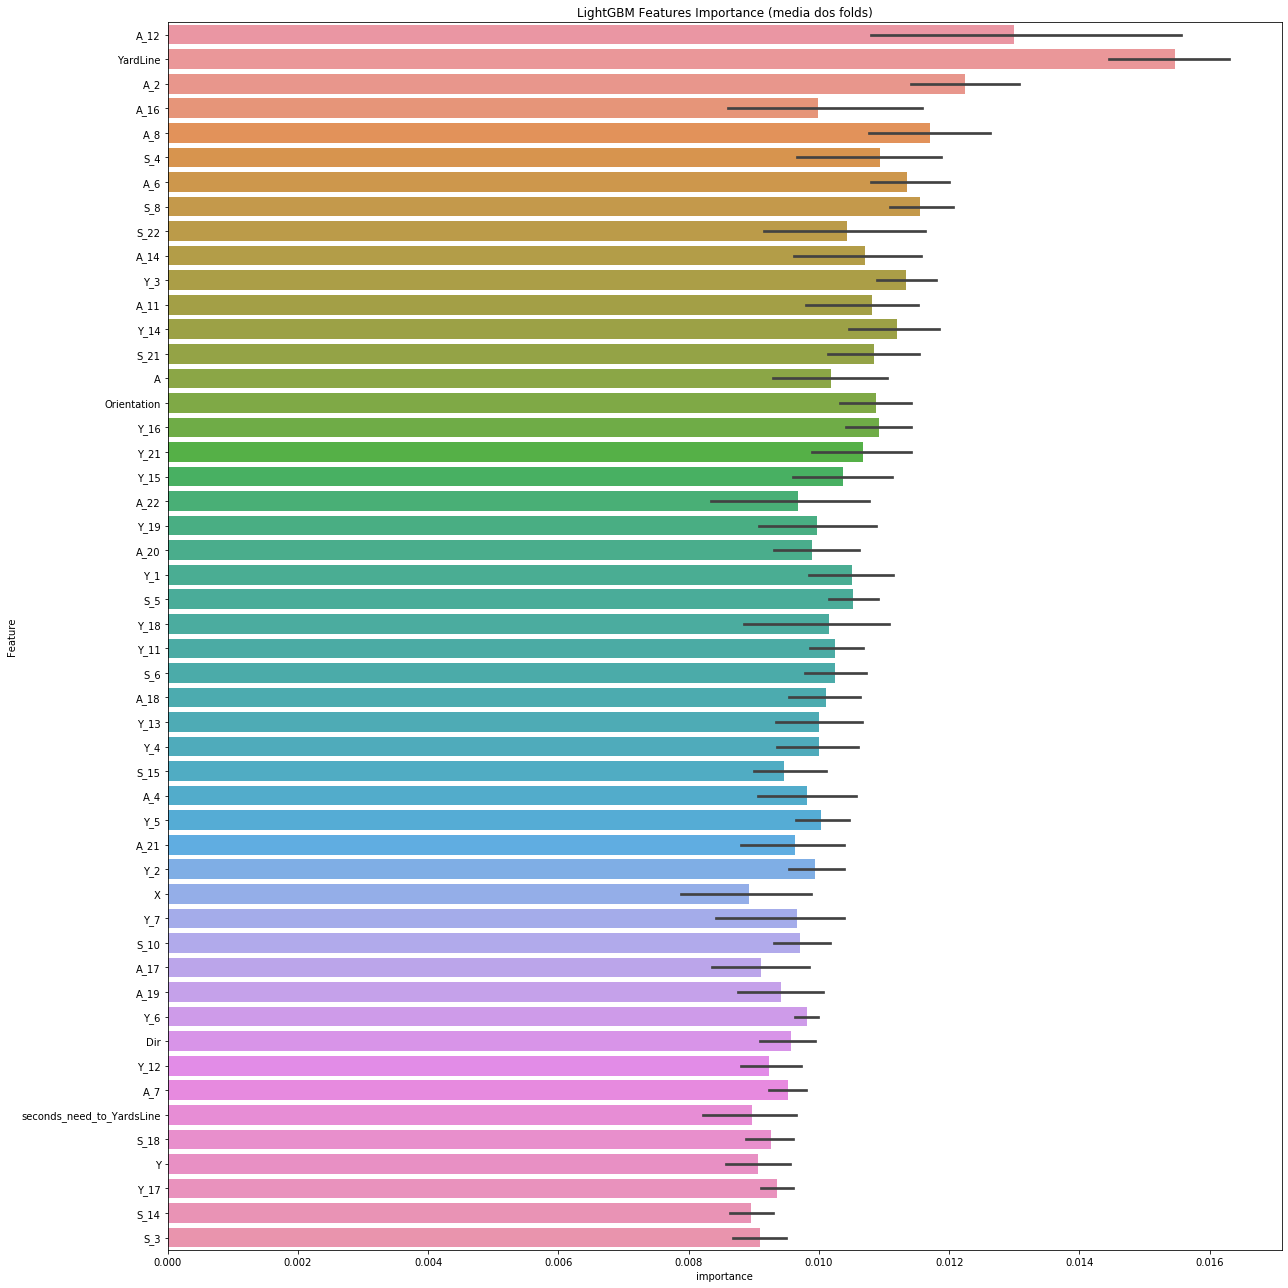

In [18]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:50].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(18,18))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features Importance (media dos folds)')
plt.tight_layout()

In [19]:
# Validacao do modelo
# Imprimir o score de treino e teste

mean_rmse_tr = np.mean(tr_rmse)
std_rmse_tr =  np.std(tr_rmse)

mean_rmse_val =  np.mean(val_rmse)
std_rmse_val =  np.std(val_rmse)

all_rmse = mean_squared_error(oof,y_tr)

print("Score de Treino")
print("Média RMSE: %.5f, std: %.5f." % (mean_rmse_tr, std_rmse_tr),'\n')

print("Score de Validação")
print("Média RMSE: %.5f, std: %.5f." % (mean_rmse_val, std_rmse_val),'\n')

print("Geral: %.5f." % (all_rmse),'\n')

print("CRPS: %.5f." % (funcao_crps(y_tr,oof)[1]))

Score de Treino
Média RMSE: 0.14627, std: 0.00459. 

Score de Validação
Média RMSE: 1.03694, std: 0.12739. 

Geral: 1.03694. 

CRPS: 0.01404.


# REALIZANDO A SUBMISSAO